# Correlation Analysis: Mergeability Metrics vs Pairwise Merging Performance

This notebook analyzes the correlation between various mergeability metrics and the performance of pairwise model merging using different merger methods.

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from typing import Dict, List, Tuple

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

In [23]:
# Paths
MERGEABILITY_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-32/pairwise_metrics_N20.json"
RESULTS_BASE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/ViT-B-32"
PLOT_SAVE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-32/correlation/plots"

# Control whether to read results files with "perm_matched" suffix
PERM_MATCHED_MERGING = False  # Set to True to read files with "perm_matched", False otherwise

# Create plot save directory if it doesn't exist
Path(PLOT_SAVE_PATH).mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {PLOT_SAVE_PATH}\n")

# Load mergeability metrics
with open(MERGEABILITY_PATH, 'r') as f:
    mergeability_data = json.load(f)

datasets = mergeability_data['datasets']
metrics = mergeability_data['metrics']

print(f"Number of datasets: {len(datasets)}")
print(f"Datasets: {datasets}")
print(f"\nMergeability metrics available: {list(metrics.keys())}")

Plots will be saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-32/correlation/plots

Number of datasets: 20
Datasets: ['SUN397', 'Cars', 'RESISC45', 'EuroSAT', 'SVHN', 'GTSRB', 'MNIST', 'DTD', 'Flowers102', 'PCAM', 'FER2013', 'OxfordIIITPet', 'STL10', 'CIFAR100', 'CIFAR10', 'Food101', 'FashionMNIST', 'EMNIST', 'KMNIST', 'RenderedSST2']

Mergeability metrics available: ['task_vector_cosine_similarity', 'task_vector_l2_distance', 'task_vector_dot_product', 'weight_space_angle', 'task_vector_magnitude_ratio', 'singular_value_overlap', 'subspace_overlap']


In [24]:
# Identify merger methods from subdirectories
results_path = Path(RESULTS_BASE_PATH)
merger_methods = [d.name for d in results_path.iterdir() if d.is_dir()]
print(f"Merger methods found: {merger_methods}")

Merger methods found: ['arithmetic', 'isotropic', 'weight_avg', 'tsv']


## 2. Extract Mergeability Metrics for Each Pair

In [25]:
def extract_mergeability_values(metrics_dict: Dict, datasets: List[str]) -> Dict[str, Dict[str, float]]:
    """
    Extract mergeability values for each dataset pair from the metrics dictionary.
    
    Returns:
        Dict mapping metric_name -> {"dataset1__dataset2": value}
    """
    mergeability_values = {}
    
    for metric_name, metric_data in metrics_dict.items():
        mergeability_values[metric_name] = {}
        matrix = metric_data['matrix']
        
        for i in range(len(datasets)):
            for j in range(i + 1, len(datasets)):
                pair_name = f"{datasets[i]}__{datasets[j]}"
                value = matrix[i][j]
                if value is not None:
                    mergeability_values[metric_name][pair_name] = value
    
    return mergeability_values

mergeability_values = extract_mergeability_values(metrics, datasets)

# Show example
example_metric = list(mergeability_values.keys())[0]
example_pairs = list(mergeability_values[example_metric].items())[:5]
print(f"\nExample - {example_metric}:")
for pair, value in example_pairs:
    print(f"  {pair}: {value:.6f}")


Example - task_vector_cosine_similarity:
  SUN397__Cars: 0.033207
  SUN397__RESISC45: 0.045997
  SUN397__EuroSAT: 0.036734
  SUN397__SVHN: 0.033133
  SUN397__GTSRB: 0.038630


## 3. Extract Performance Values for Each Pair and Merger

In [26]:
def extract_performance_values(base_path: str, merger_method: str) -> Dict[str, float]:
    """
    Extract performance values for each dataset pair using a specific merger method.
    Finds all pair_TaskA__TaskB.json files in the merger folder.

    Returns:
        Dict mapping "dataset1__dataset2" -> avg normalized accuracy
    """
    performance_values = {}
    merger_path = Path(base_path) / merger_method

    if not merger_path.exists():
        print(f"Warning: {merger_path} does not exist")
        return performance_values

    # Find all JSON files that start with "pair_" (excluding "all_pairwise" etc.)
    for file_path in merger_path.glob("*.json"):
        try:
            filename = file_path.stem  # removes .json
            
            # ONLY process files that start with "pair_" (not "all_pairwise" or anything else)
            if not filename.startswith("pair_"):
                continue
            
            # Filter based on PERM_MATCHED_MERGING setting
            has_perm_matched = "_perm_matched" in filename
            if PERM_MATCHED_MERGING and not has_perm_matched:
                continue  # Skip files without "perm_matched" when we want them
            if not PERM_MATCHED_MERGING and has_perm_matched:
                continue  # Skip files with "perm_matched" when we don't want them
            
            # Extract pair name from filename: "pair_SUN397__Cars" -> "SUN397__Cars"
            # or "pair_SUN397__Cars_perm_matched" -> "SUN397__Cars"
            pair_name = filename[5:]  # Remove "pair_" prefix
            
            # Remove "_perm_matched" suffix if present
            if pair_name.endswith("_perm_matched"):
                pair_name = pair_name[:-13]  # Remove "_perm_matched"
            
            # Validate that it contains "__" to separate the two tasks
            if "__" not in pair_name:
                continue

            # Read the file and extract performance
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Extract average normalized accuracy
            if 'avg' in data and len(data['avg']) > 0:
                avg_normalized_acc = data['avg'][0].get('normalized_acc/test/avg', None)
                if avg_normalized_acc is not None:
                    performance_values[pair_name] = avg_normalized_acc
                    
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return performance_values

# Extract performance for all merger methods
performance_by_merger = {}
for merger in merger_methods:
    performance_by_merger[merger] = extract_performance_values(RESULTS_BASE_PATH, merger)
    print(f"\n{merger}: Found {len(performance_by_merger[merger])} pairs")

    # Show examples
    if len(performance_by_merger[merger]) > 0:
        example_pairs = list(performance_by_merger[merger].items())[:3]
        for pair, perf in example_pairs:
            print(f"  {pair}: {perf:.4f}")
    else:
        print(f"  No performance data found")


arithmetic: Found 190 pairs
  EuroSAT__MNIST: 0.9600
  CIFAR100__KMNIST: 0.7136
  EuroSAT__STL10: 0.9850

isotropic: Found 178 pairs
  CIFAR100__EMNIST: 0.9053
  EuroSAT__DTD: 0.8038
  SVHN__DTD: 0.7585

weight_avg: Found 190 pairs
  MNIST__EMNIST: 1.0018
  RESISC45__STL10: 0.9833
  Flowers102__EMNIST: 0.9198

tsv: Found 174 pairs
  GTSRB__KMNIST: 0.9841
  RESISC45__CIFAR100: 0.9810
  SVHN__Food101: 0.9810


## 4. Create Correlation Data

In [27]:
def create_correlation_data(mergeability_values: Dict[str, Dict[str, float]], 
                           performance_values: Dict[str, float], 
                           metric_name: str) -> Tuple[List[float], List[float], List[str]]:
    """
    Create aligned lists of mergeability and performance values for correlation analysis.
    
    Returns:
        (mergeability_list, performance_list, pair_names)
    """
    mergeability_list = []
    performance_list = []
    pair_names = []
    
    metric_values = mergeability_values[metric_name]
    
    for pair_name in metric_values.keys():
        if pair_name in performance_values:
            mergeability_list.append(metric_values[pair_name])
            performance_list.append(performance_values[pair_name])
            pair_names.append(pair_name)
    
    return mergeability_list, performance_list, pair_names

# Test with one example
test_metric = list(mergeability_values.keys())[0]
test_merger = merger_methods[0]
test_x, test_y, test_names = create_correlation_data(
    mergeability_values, 
    performance_by_merger[test_merger], 
    test_metric
)
print(f"\nTest: {test_metric} vs {test_merger}")
print(f"Number of data points: {len(test_x)}")
print(f"Example pairs: {test_names[:3]}")


Test: task_vector_cosine_similarity vs arithmetic
Number of data points: 190
Example pairs: ['SUN397__Cars', 'SUN397__RESISC45', 'SUN397__EuroSAT']


## 5. Generate All Scatter Plots

In [28]:
def create_scatter_plot(mergeability_vals: List[float], 
                       performance_vals: List[float],
                       pair_names: List[str],
                       metric_name: str,
                       merger_name: str,
                       ax=None):
    """
    Create a scatter plot with correlation statistics.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate correlations
    if len(mergeability_vals) > 2:
        pearson_r, pearson_p = pearsonr(mergeability_vals, performance_vals)
        spearman_r, spearman_p = spearmanr(mergeability_vals, performance_vals)
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
    
    # Create scatter plot
    ax.scatter(mergeability_vals, performance_vals, alpha=0.6, s=50)
    
    # Add trend line
    if len(mergeability_vals) > 1:
        z = np.polyfit(mergeability_vals, performance_vals, 1)
        p = np.poly1d(z)
        x_line = np.linspace(min(mergeability_vals), max(mergeability_vals), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)
    
    # Labels and title
    ax.set_xlabel(f"{metric_name}", fontsize=11)
    ax.set_ylabel("Normalized Accuracy (Avg)", fontsize=11)
    ax.set_title(f"{merger_name}: {metric_name}\nPearson r={pearson_r:.3f} (p={pearson_p:.3e}), Spearman ρ={spearman_r:.3f} (p={spearman_p:.3e})",
                fontsize=11, pad=10)
    
    ax.grid(True, alpha=0.3)
    
    return pearson_r, pearson_p, spearman_r, spearman_p

Generating 7 x 4 = 28 scatter plots...


Merger: ARITHMETIC


Saved: arithmetic_task_vector_cosine_similarity.png


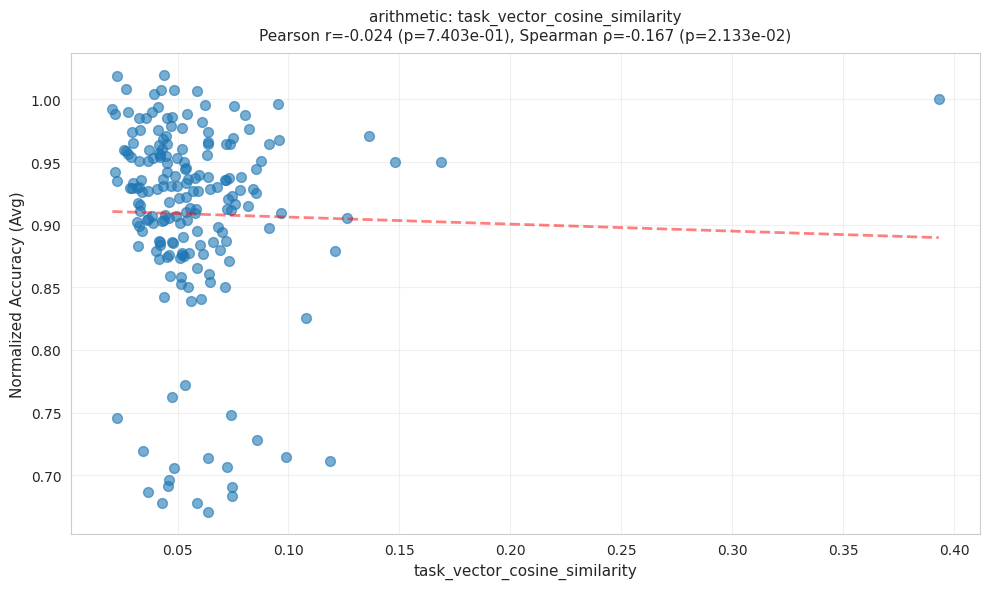


task_vector_cosine_similarity:
  Data points: 190
  Pearson correlation: r=-0.0242, p=7.4030e-01
  Spearman correlation: ρ=-0.1669, p=2.1335e-02
Saved: arithmetic_task_vector_l2_distance.png


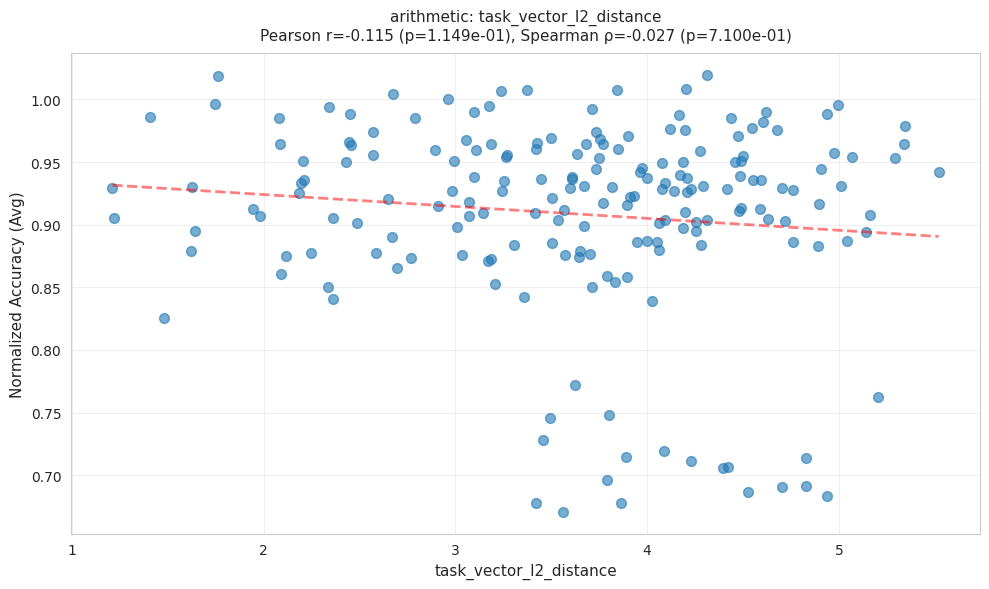


task_vector_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.1148, p=1.1489e-01
  Spearman correlation: ρ=-0.0272, p=7.0999e-01
Saved: arithmetic_task_vector_dot_product.png


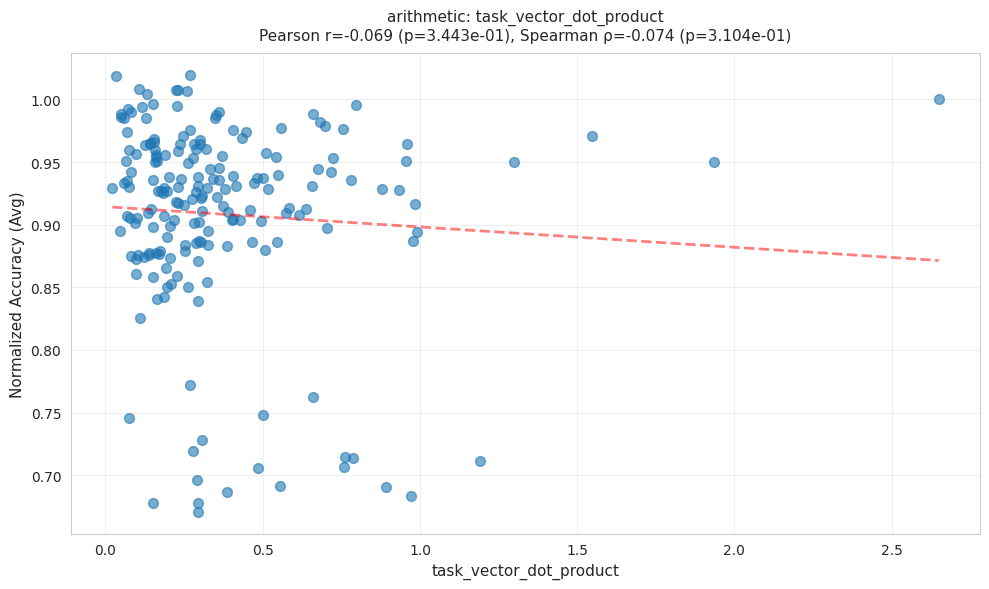


task_vector_dot_product:
  Data points: 190
  Pearson correlation: r=-0.0690, p=3.4429e-01
  Spearman correlation: ρ=-0.0740, p=3.1041e-01
Saved: arithmetic_weight_space_angle.png


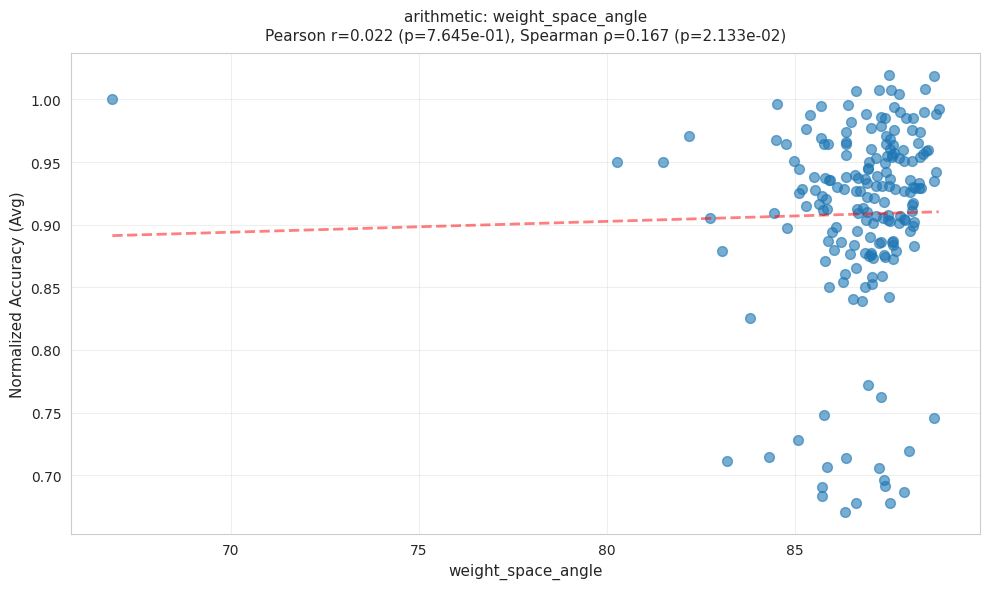


weight_space_angle:
  Data points: 190
  Pearson correlation: r=0.0219, p=7.6454e-01
  Spearman correlation: ρ=0.1669, p=2.1335e-02
Saved: arithmetic_task_vector_magnitude_ratio.png


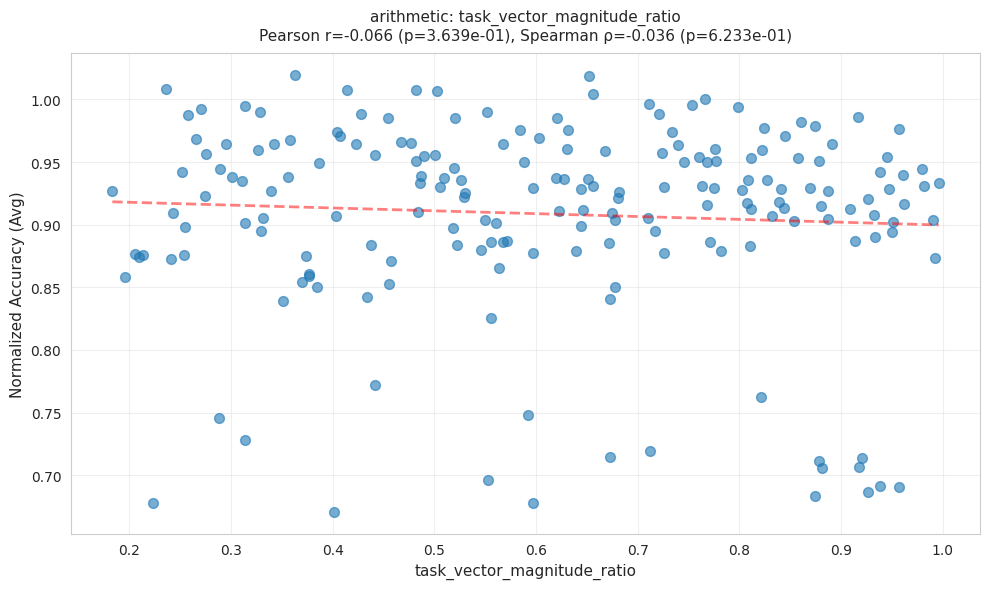


task_vector_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=-0.0662, p=3.6387e-01
  Spearman correlation: ρ=-0.0359, p=6.2331e-01
Saved: arithmetic_singular_value_overlap.png


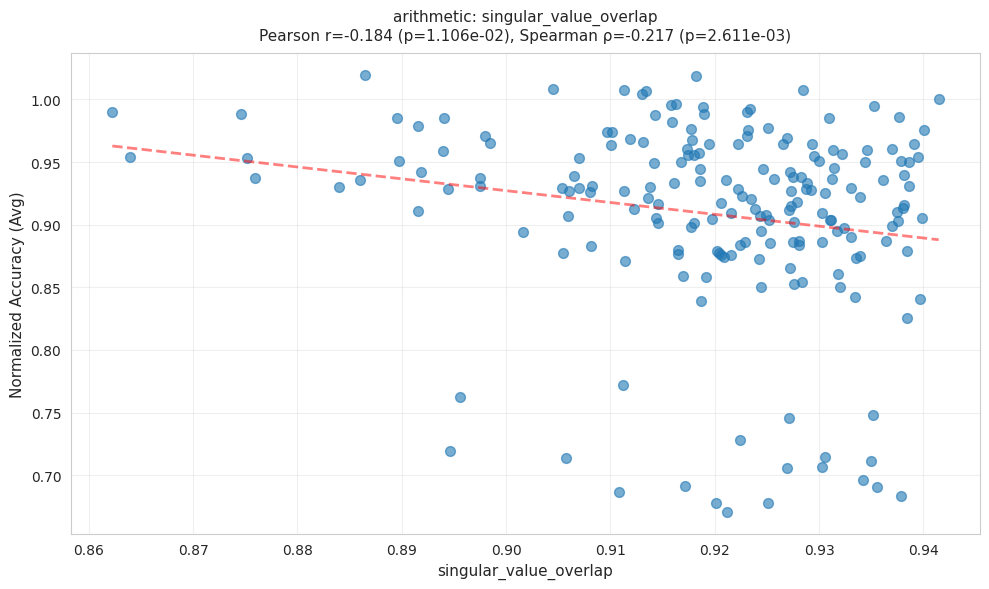


singular_value_overlap:
  Data points: 190
  Pearson correlation: r=-0.1840, p=1.1064e-02
  Spearman correlation: ρ=-0.2172, p=2.6109e-03
Saved: arithmetic_subspace_overlap.png


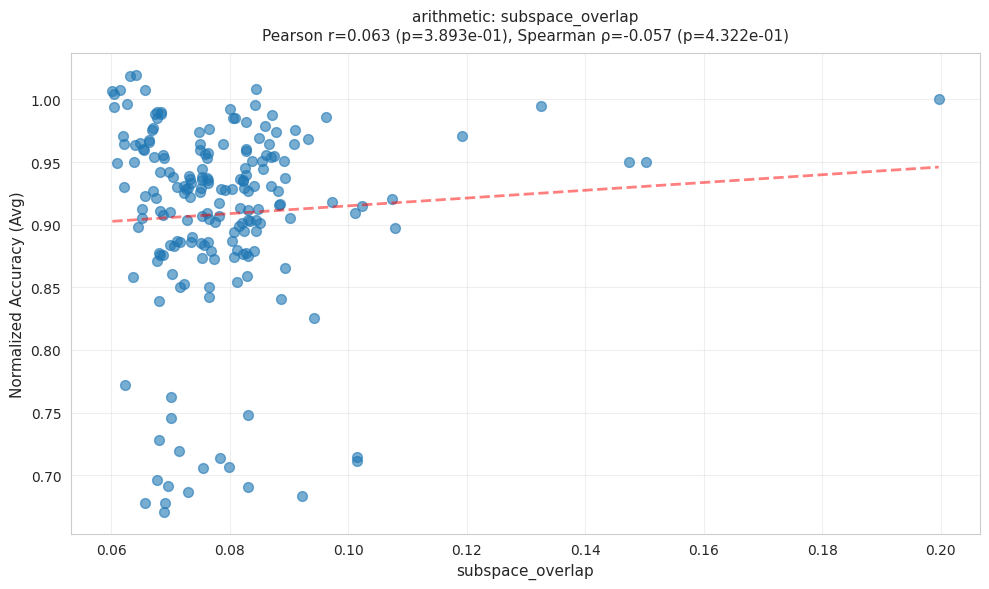


subspace_overlap:
  Data points: 190
  Pearson correlation: r=0.0628, p=3.8929e-01
  Spearman correlation: ρ=-0.0573, p=4.3225e-01

Merger: ISOTROPIC
Saved: isotropic_task_vector_cosine_similarity.png


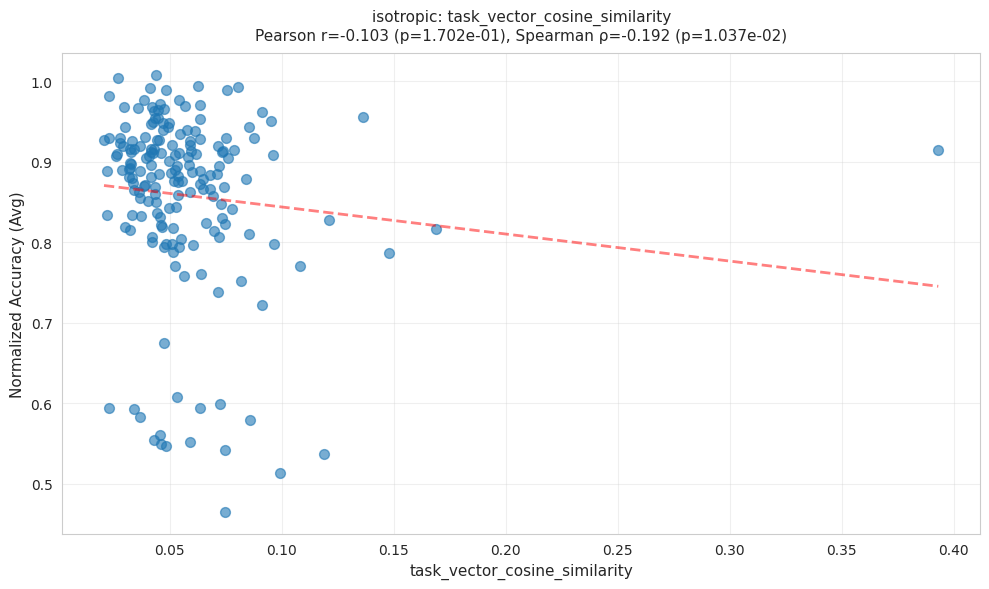


task_vector_cosine_similarity:
  Data points: 178
  Pearson correlation: r=-0.1032, p=1.7023e-01
  Spearman correlation: ρ=-0.1917, p=1.0367e-02
Saved: isotropic_task_vector_l2_distance.png


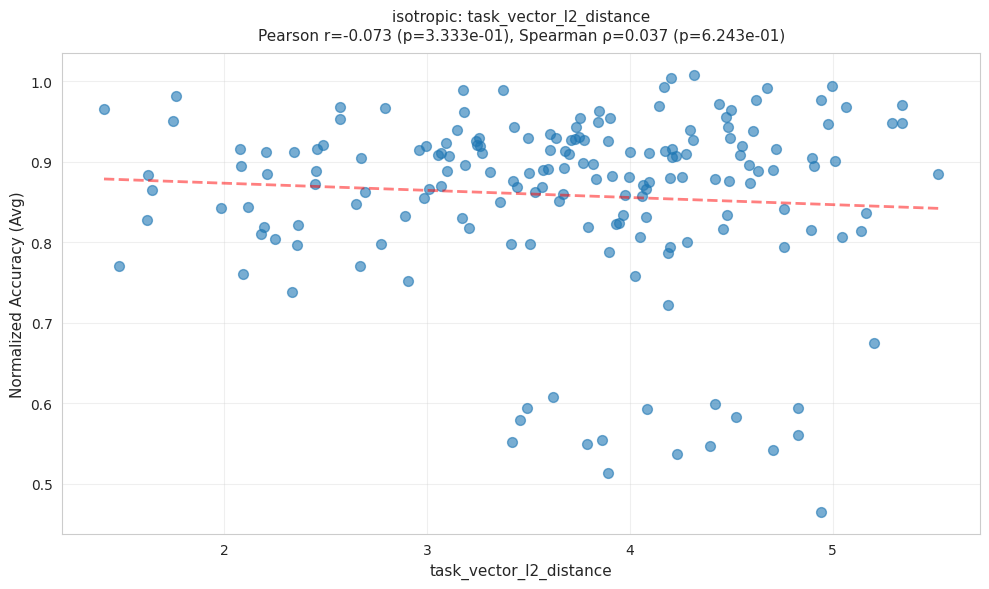


task_vector_l2_distance:
  Data points: 178
  Pearson correlation: r=-0.0729, p=3.3326e-01
  Spearman correlation: ρ=0.0370, p=6.2434e-01
Saved: isotropic_task_vector_dot_product.png


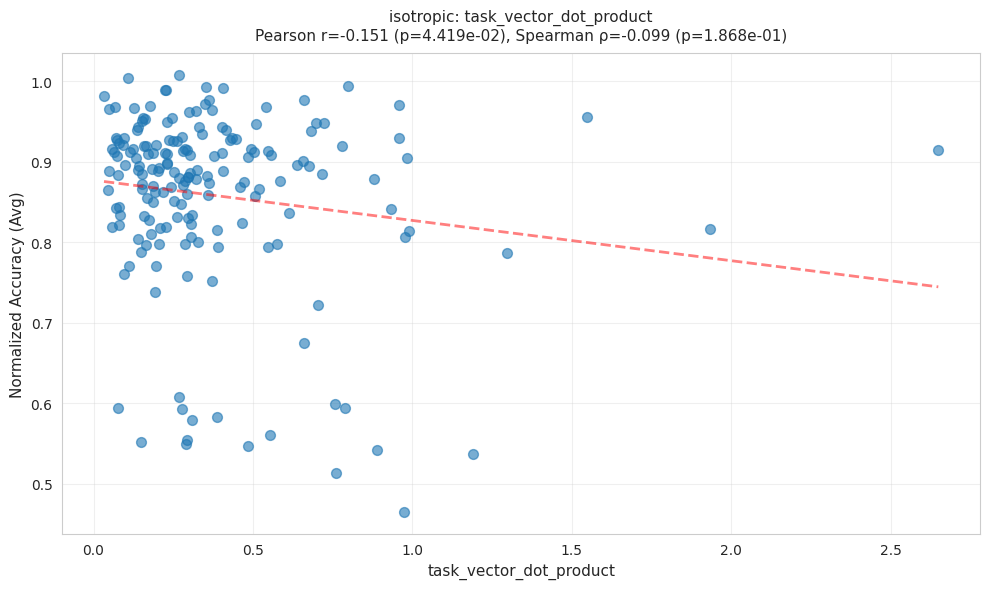


task_vector_dot_product:
  Data points: 178
  Pearson correlation: r=-0.1510, p=4.4187e-02
  Spearman correlation: ρ=-0.0994, p=1.8682e-01
Saved: isotropic_weight_space_angle.png


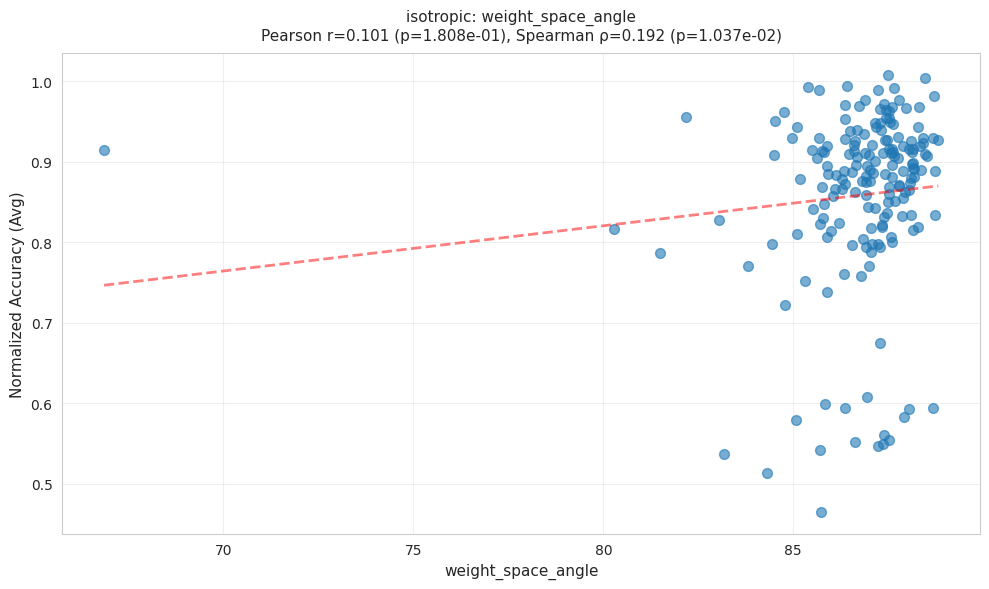


weight_space_angle:
  Data points: 178
  Pearson correlation: r=0.1008, p=1.8076e-01
  Spearman correlation: ρ=0.1917, p=1.0367e-02
Saved: isotropic_task_vector_magnitude_ratio.png


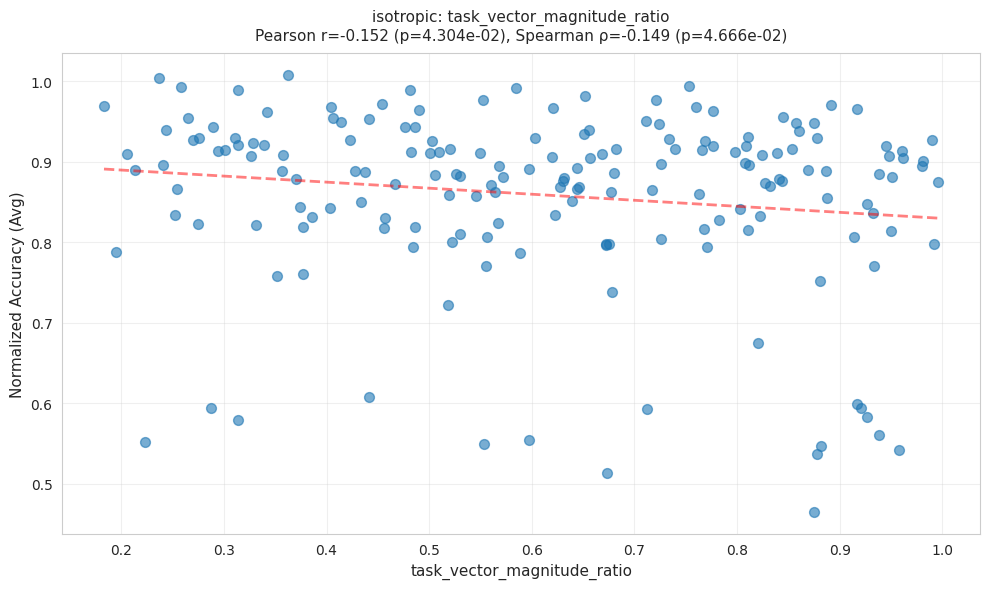


task_vector_magnitude_ratio:
  Data points: 178
  Pearson correlation: r=-0.1518, p=4.3040e-02
  Spearman correlation: ρ=-0.1493, p=4.6660e-02
Saved: isotropic_singular_value_overlap.png


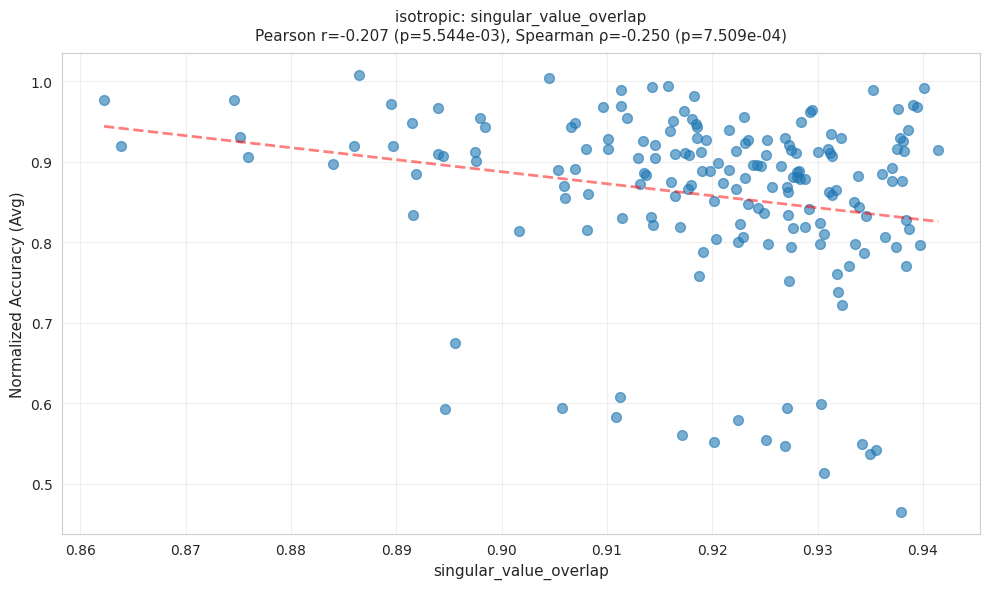


singular_value_overlap:
  Data points: 178
  Pearson correlation: r=-0.2071, p=5.5437e-03
  Spearman correlation: ρ=-0.2503, p=7.5087e-04
Saved: isotropic_subspace_overlap.png


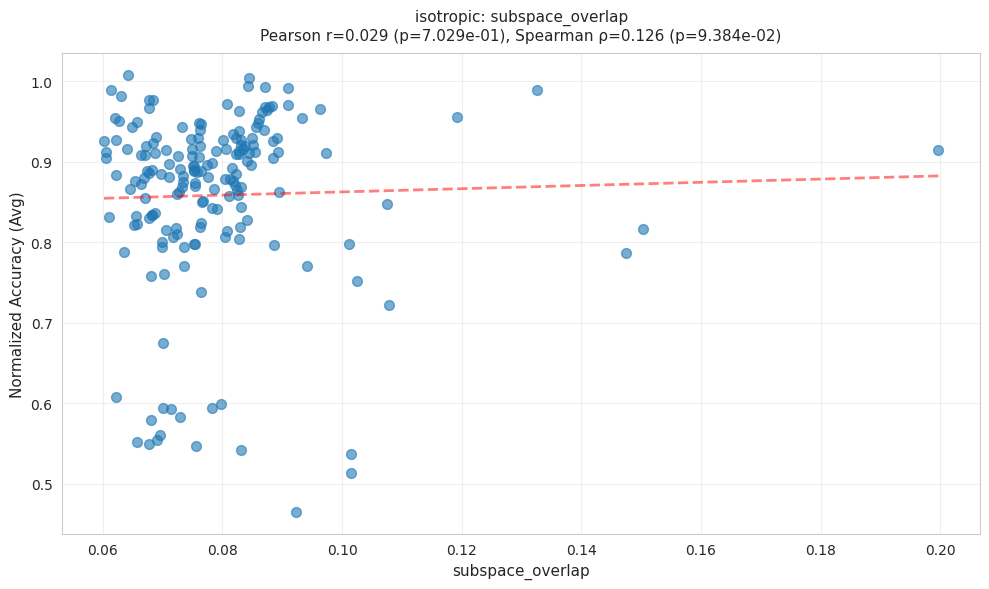


subspace_overlap:
  Data points: 178
  Pearson correlation: r=0.0288, p=7.0295e-01
  Spearman correlation: ρ=0.1260, p=9.3838e-02

Merger: WEIGHT_AVG
Saved: weight_avg_task_vector_cosine_similarity.png


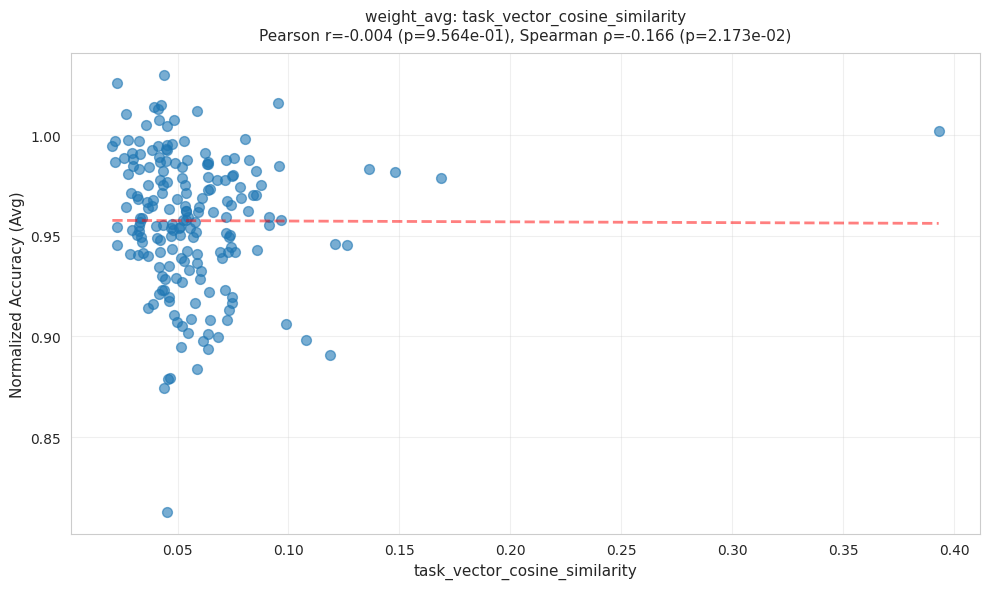


task_vector_cosine_similarity:
  Data points: 190
  Pearson correlation: r=-0.0040, p=9.5645e-01
  Spearman correlation: ρ=-0.1664, p=2.1731e-02
Saved: weight_avg_task_vector_l2_distance.png


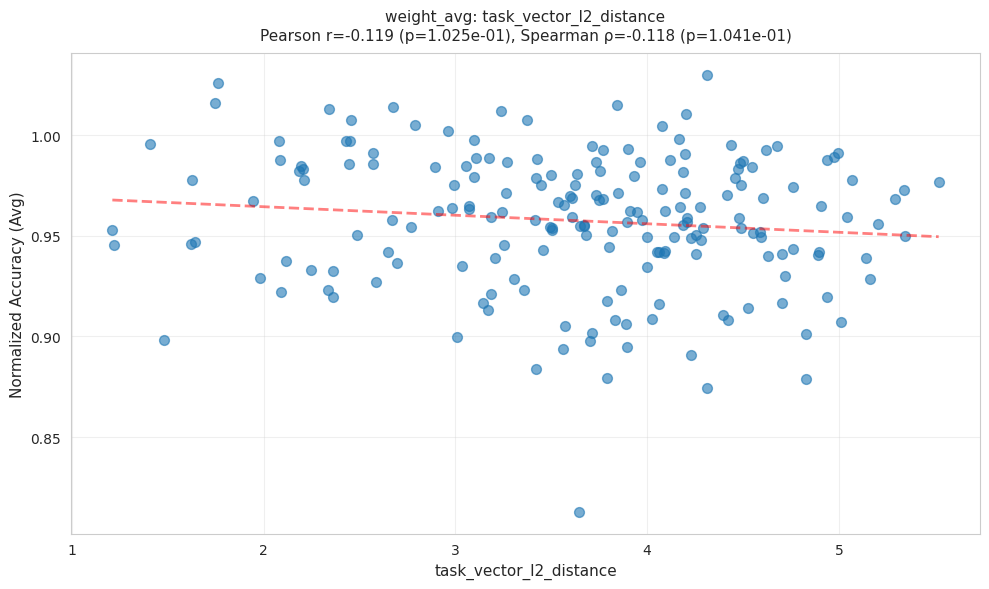


task_vector_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.1188, p=1.0251e-01
  Spearman correlation: ρ=-0.1183, p=1.0405e-01
Saved: weight_avg_task_vector_dot_product.png


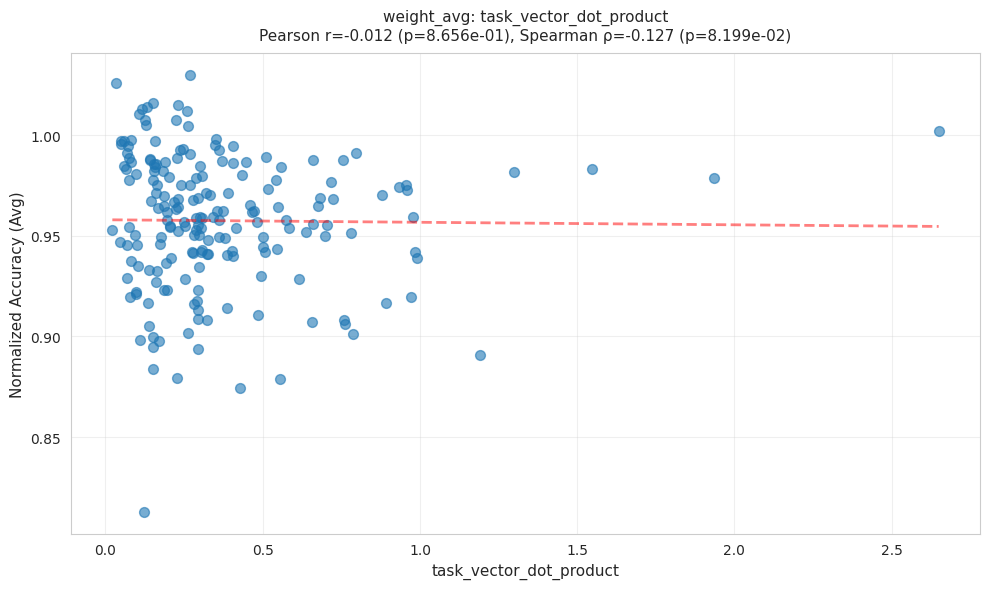


task_vector_dot_product:
  Data points: 190
  Pearson correlation: r=-0.0124, p=8.6561e-01
  Spearman correlation: ρ=-0.1265, p=8.1987e-02
Saved: weight_avg_weight_space_angle.png


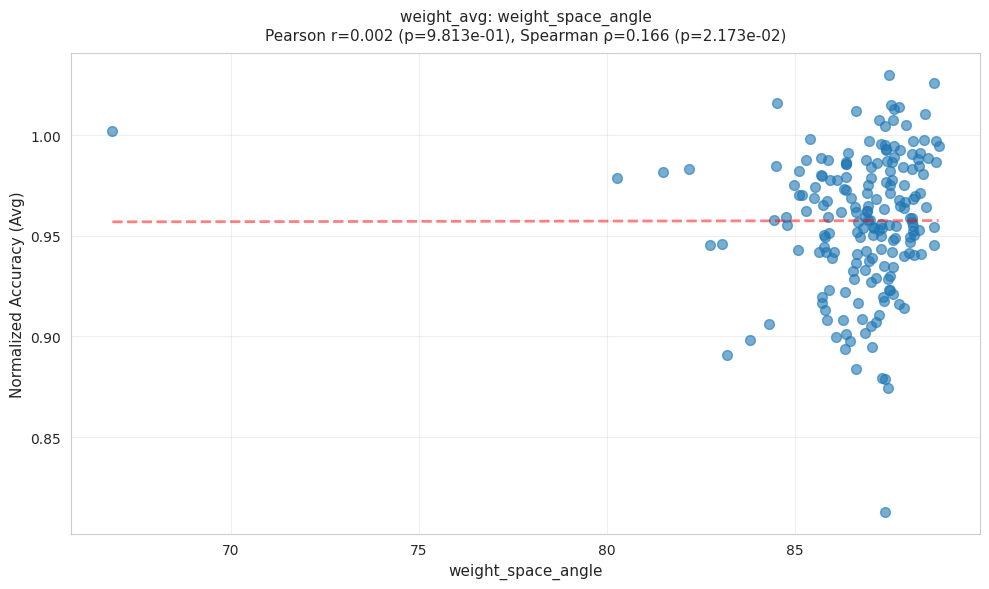


weight_space_angle:
  Data points: 190
  Pearson correlation: r=0.0017, p=9.8130e-01
  Spearman correlation: ρ=0.1664, p=2.1731e-02
Saved: weight_avg_task_vector_magnitude_ratio.png


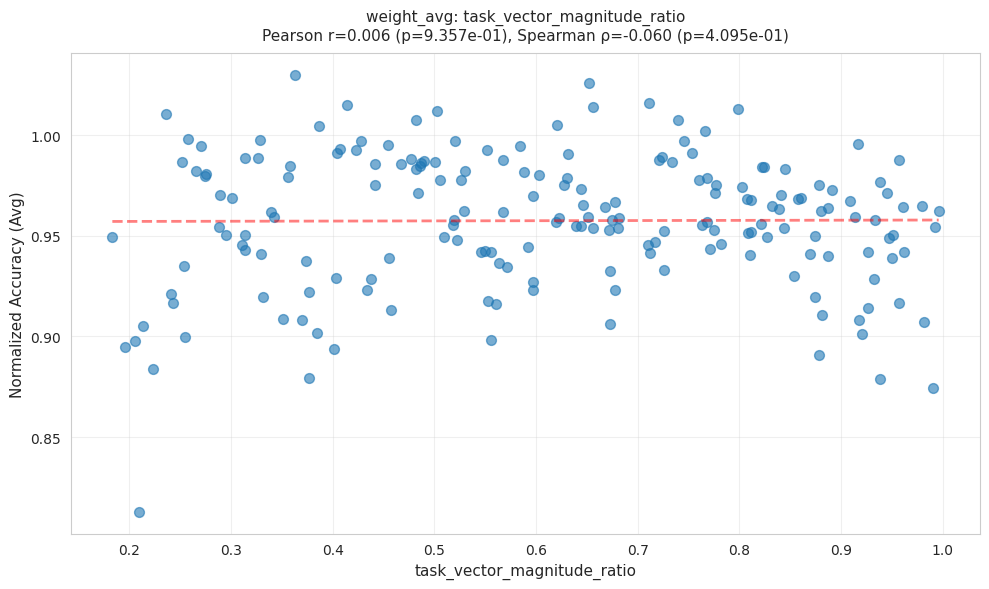


task_vector_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=0.0059, p=9.3569e-01
  Spearman correlation: ρ=-0.0602, p=4.0949e-01
Saved: weight_avg_singular_value_overlap.png


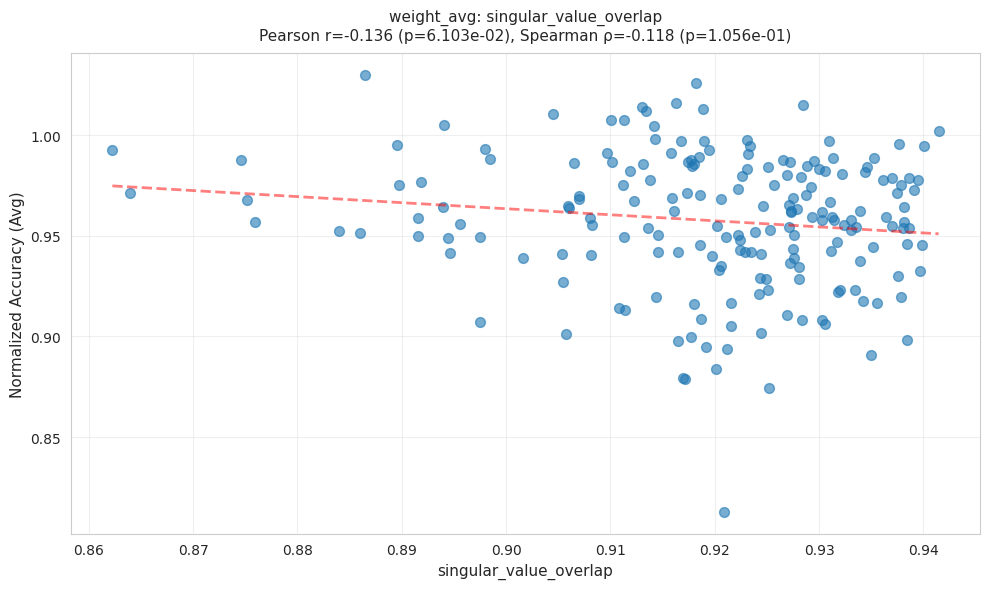


singular_value_overlap:
  Data points: 190
  Pearson correlation: r=-0.1362, p=6.1034e-02
  Spearman correlation: ρ=-0.1178, p=1.0565e-01
Saved: weight_avg_subspace_overlap.png


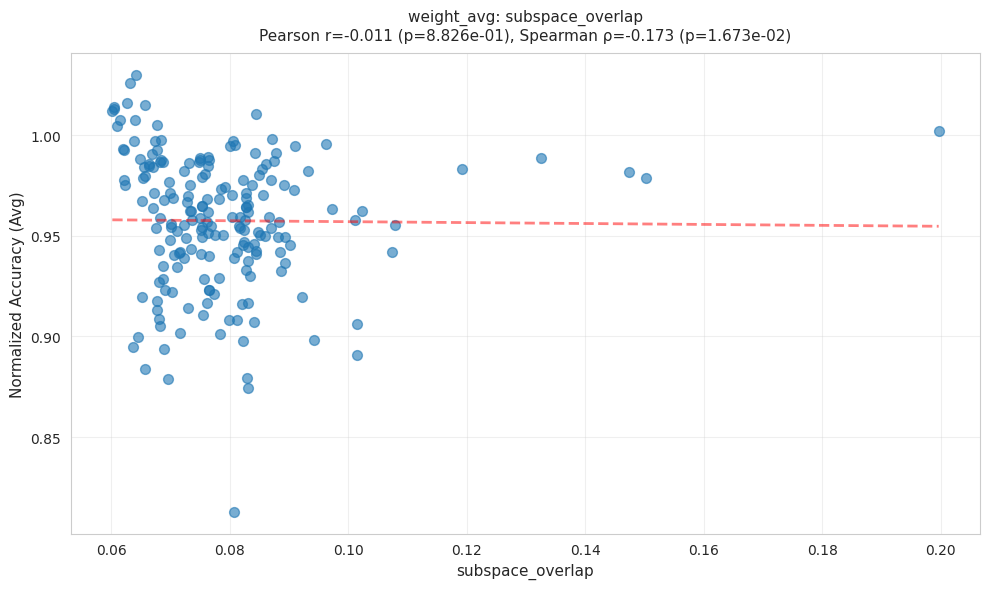


subspace_overlap:
  Data points: 190
  Pearson correlation: r=-0.0108, p=8.8265e-01
  Spearman correlation: ρ=-0.1734, p=1.6726e-02

Merger: TSV
Saved: tsv_task_vector_cosine_similarity.png


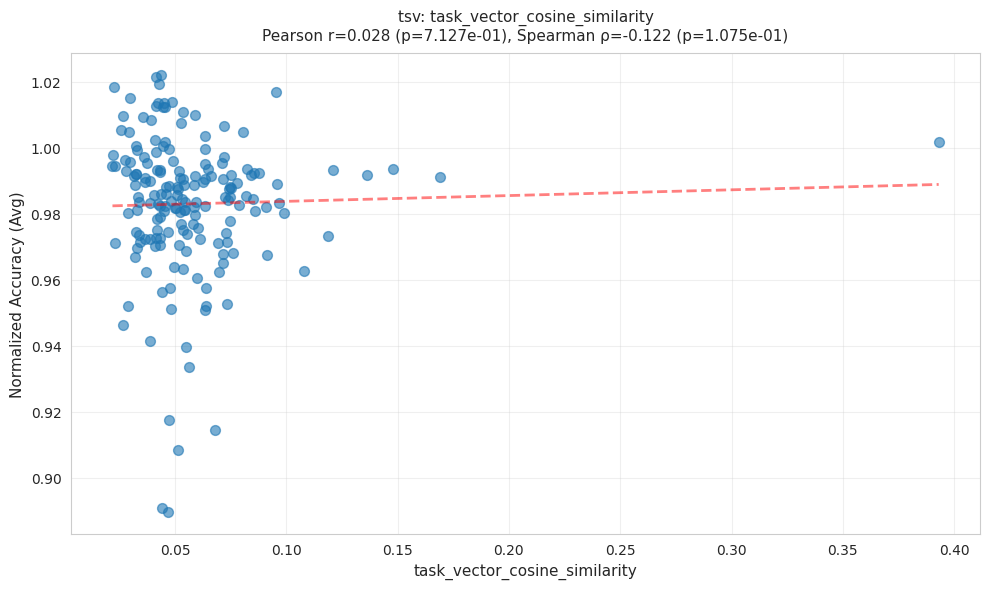


task_vector_cosine_similarity:
  Data points: 174
  Pearson correlation: r=0.0281, p=7.1274e-01
  Spearman correlation: ρ=-0.1224, p=1.0748e-01
Saved: tsv_task_vector_l2_distance.png


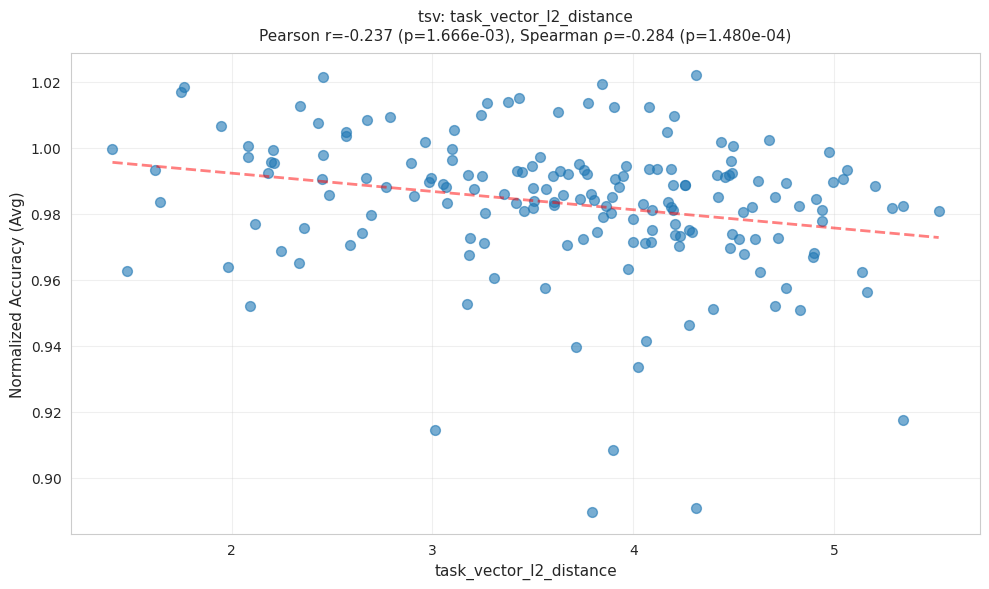


task_vector_l2_distance:
  Data points: 174
  Pearson correlation: r=-0.2367, p=1.6663e-03
  Spearman correlation: ρ=-0.2838, p=1.4798e-04
Saved: tsv_task_vector_dot_product.png


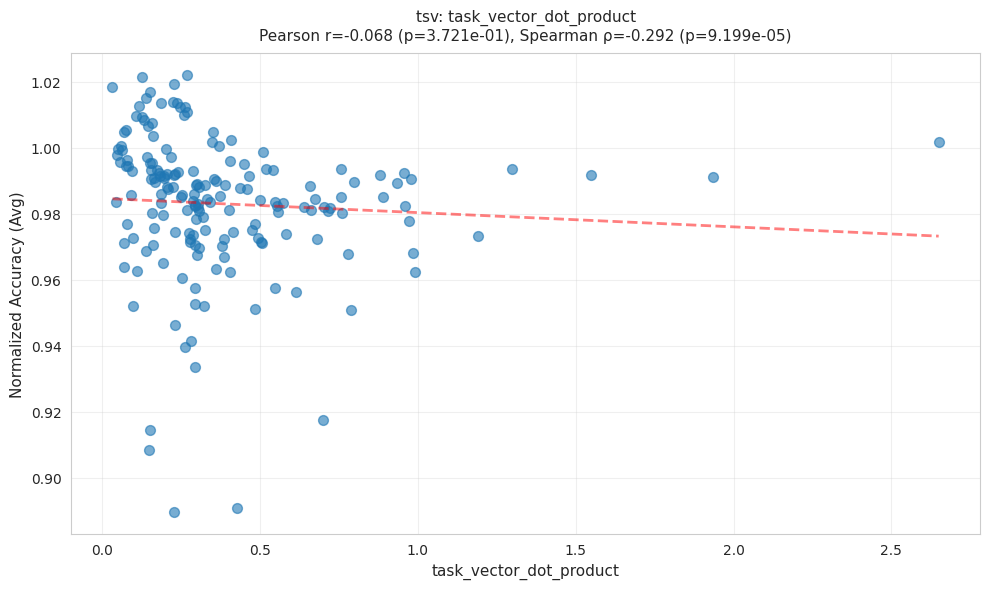


task_vector_dot_product:
  Data points: 174
  Pearson correlation: r=-0.0681, p=3.7208e-01
  Spearman correlation: ρ=-0.2921, p=9.1986e-05
Saved: tsv_weight_space_angle.png


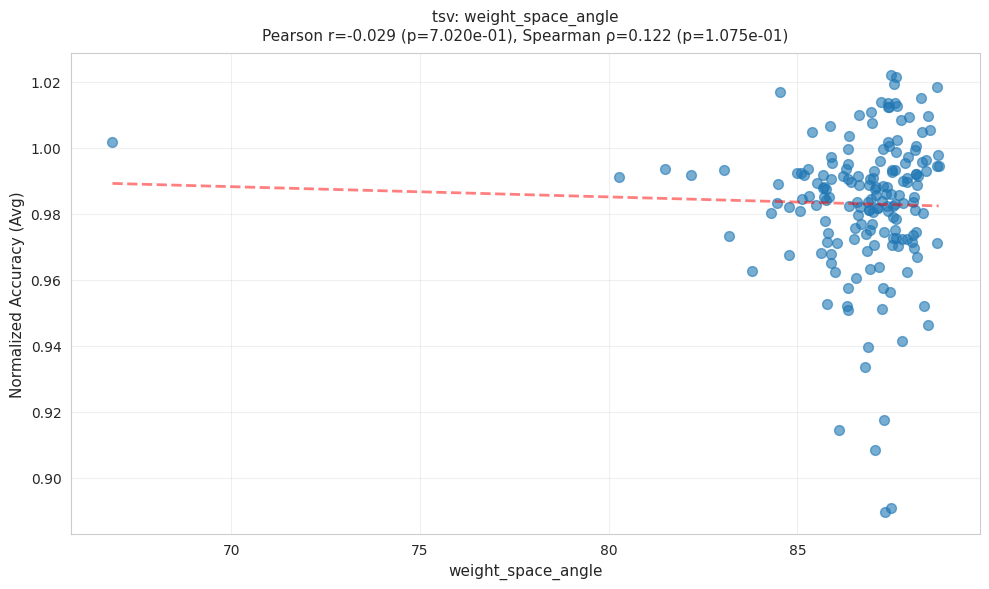


weight_space_angle:
  Data points: 174
  Pearson correlation: r=-0.0292, p=7.0200e-01
  Spearman correlation: ρ=0.1224, p=1.0748e-01
Saved: tsv_task_vector_magnitude_ratio.png


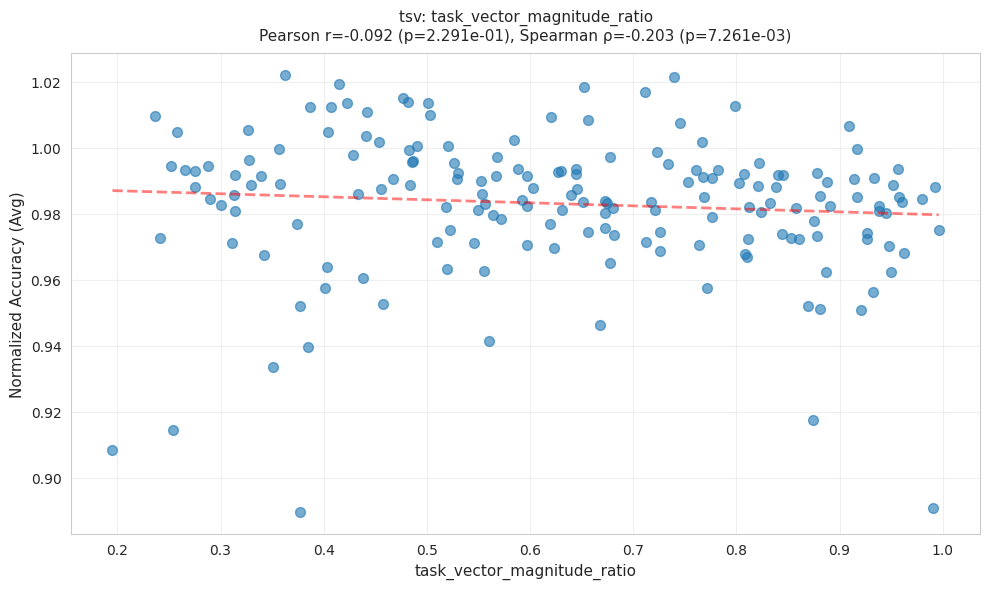


task_vector_magnitude_ratio:
  Data points: 174
  Pearson correlation: r=-0.0916, p=2.2909e-01
  Spearman correlation: ρ=-0.2029, p=7.2608e-03
Saved: tsv_singular_value_overlap.png


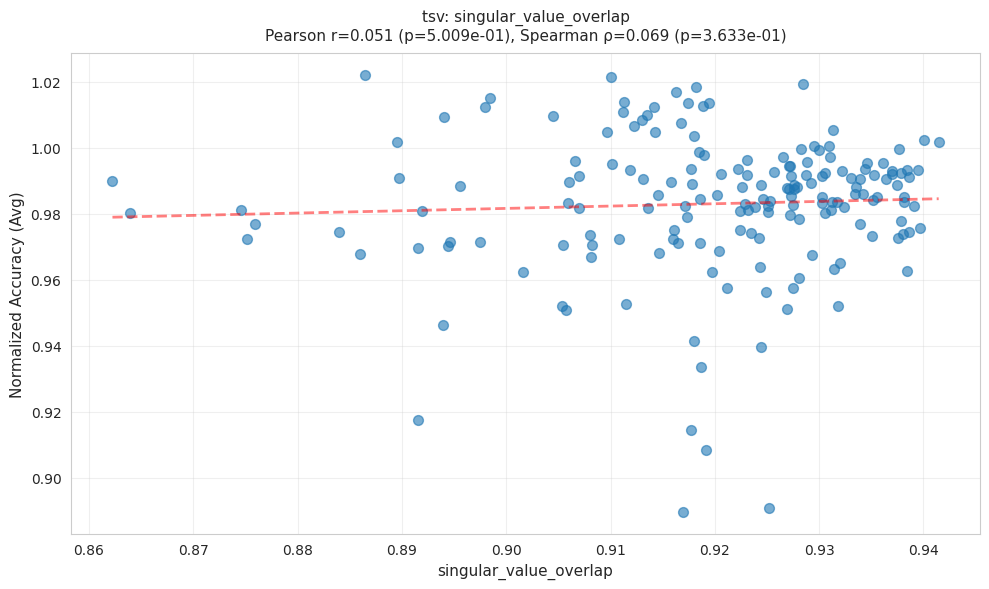


singular_value_overlap:
  Data points: 174
  Pearson correlation: r=0.0514, p=5.0088e-01
  Spearman correlation: ρ=0.0693, p=3.6328e-01
Saved: tsv_subspace_overlap.png


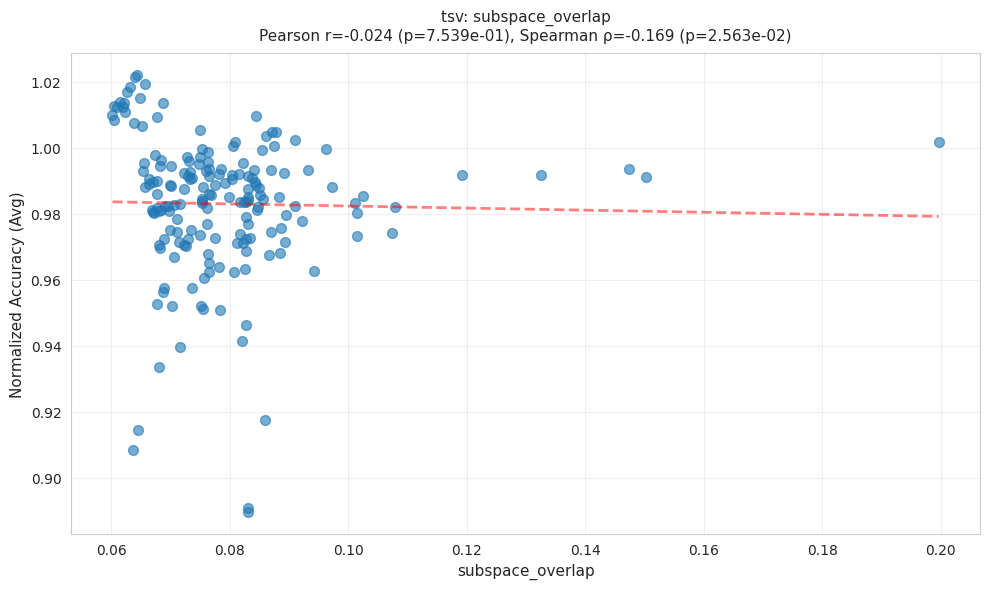


subspace_overlap:
  Data points: 174
  Pearson correlation: r=-0.0239, p=7.5385e-01
  Spearman correlation: ρ=-0.1692, p=2.5626e-02


In [29]:
# Generate all scatter plots
metric_names = list(mergeability_values.keys())
n_metrics = len(metric_names)
n_mergers = len(merger_methods)

print(f"Generating {n_metrics} x {n_mergers} = {n_metrics * n_mergers} scatter plots...\n")

# Store correlation results
correlation_results = []

for merger in merger_methods:
    print(f"\n{'='*80}")
    print(f"Merger: {merger.upper()}")
    print(f"{'='*80}")
    
    for metric in metric_names:
        x_vals, y_vals, pair_names = create_correlation_data(
            mergeability_values,
            performance_by_merger[merger],
            metric
        )
        
        if len(x_vals) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            pearson_r, pearson_p, spearman_r, spearman_p = create_scatter_plot(
                x_vals, y_vals, pair_names, metric, merger, ax
            )
            plt.tight_layout()
            
            # Save the plot
            plot_filename = f"{merger}_{metric}.png"
            plot_path = Path(PLOT_SAVE_PATH) / plot_filename
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {plot_filename}")
            
            plt.show()
            
            # Store results
            correlation_results.append({
                'merger': merger,
                'metric': metric,
                'n_pairs': len(x_vals),
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p
            })
            
            print(f"\n{metric}:")
            print(f"  Data points: {len(x_vals)}")
            print(f"  Pearson correlation: r={pearson_r:.4f}, p={pearson_p:.4e}")
            print(f"  Spearman correlation: ρ={spearman_r:.4f}, p={spearman_p:.4e}")
        else:
            print(f"\n{metric}: No data available")

## 6. Summary of Correlations

In [30]:
# Create summary dataframe
correlation_df = pd.DataFrame(correlation_results)
print("\nCorrelation Summary:")
print(correlation_df.to_string(index=False))


Correlation Summary:
    merger                        metric  n_pairs  pearson_r  pearson_p  spearman_r  spearman_p
arithmetic task_vector_cosine_similarity      190  -0.024202   0.740301   -0.166933    0.021335
arithmetic       task_vector_l2_distance      190  -0.114758   0.114887   -0.027153    0.709989
arithmetic       task_vector_dot_product      190  -0.068983   0.344291   -0.073976    0.310413
arithmetic            weight_space_angle      190   0.021872   0.764540    0.166933    0.021335
arithmetic   task_vector_magnitude_ratio      190  -0.066240   0.363867   -0.035858    0.623306
arithmetic        singular_value_overlap      190  -0.183958   0.011064   -0.217202    0.002611
arithmetic              subspace_overlap      190   0.062809   0.389294   -0.057306    0.432250
 isotropic task_vector_cosine_similarity      178  -0.103249   0.170227   -0.191696    0.010367
 isotropic       task_vector_l2_distance      178  -0.072939   0.333262    0.036953    0.624342
 isotropic       t

Saved: correlation_heatmaps.png


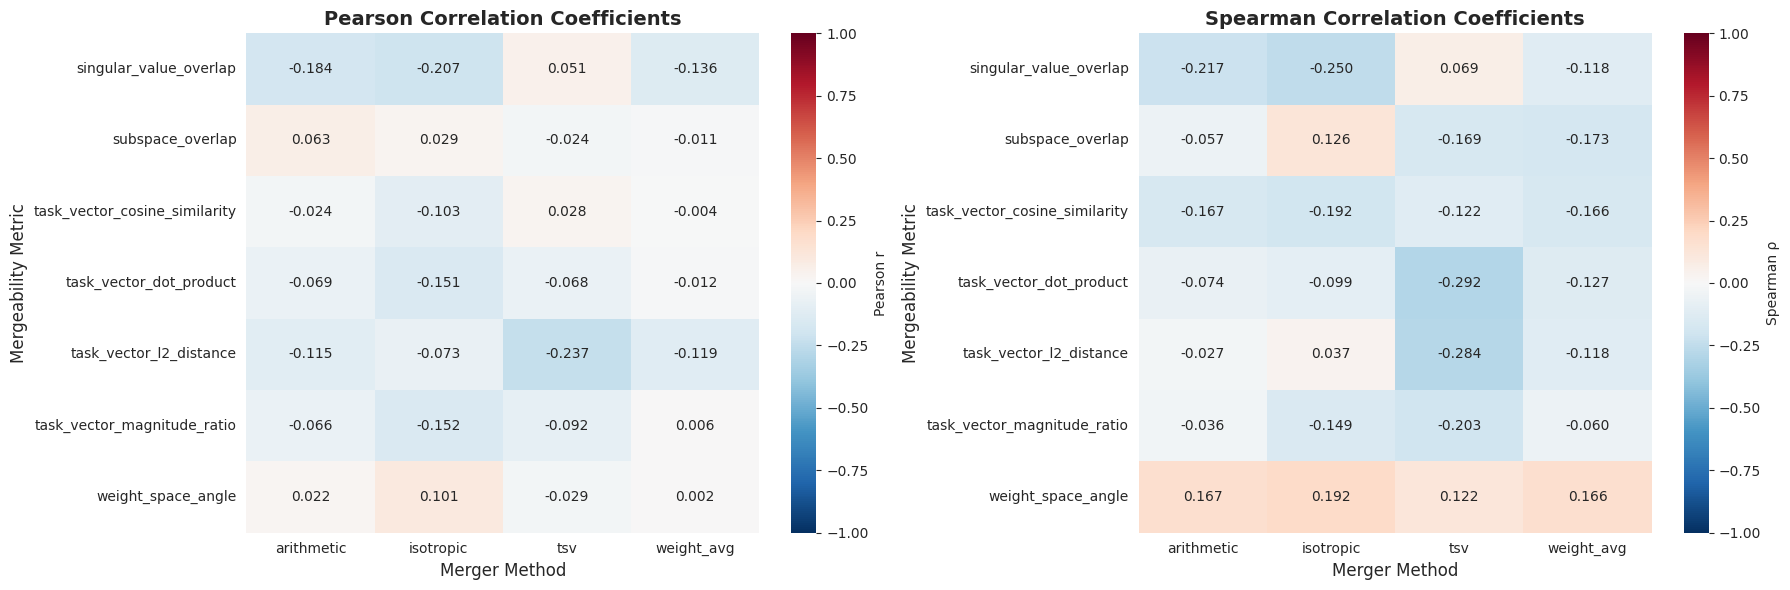

In [31]:
# Visualize correlation strengths as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pearson correlation heatmap
pearson_pivot = correlation_df.pivot(index='metric', columns='merger', values='pearson_r')
sns.heatmap(pearson_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Pearson r'})
axes[0].set_title('Pearson Correlation Coefficients', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Merger Method', fontsize=12)
axes[0].set_ylabel('Mergeability Metric', fontsize=12)

# Spearman correlation heatmap
spearman_pivot = correlation_df.pivot(index='metric', columns='merger', values='spearman_r')
sns.heatmap(spearman_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Spearman ρ'})
axes[1].set_title('Spearman Correlation Coefficients', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Merger Method', fontsize=12)
axes[1].set_ylabel('Mergeability Metric', fontsize=12)

plt.tight_layout()

# Save the heatmap
heatmap_path = Path(PLOT_SAVE_PATH) / "correlation_heatmaps.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"Saved: correlation_heatmaps.png")

plt.show()

## 7. Statistical Significance Analysis

In [32]:
# Filter for statistically significant correlations (p < 0.05)
significant_correlations = correlation_df[
    (correlation_df['pearson_p'] < 0.05) | (correlation_df['spearman_p'] < 0.05)
].copy()

if len(significant_correlations) > 0:
    print("\nStatistically Significant Correlations (p < 0.05):")
    print("="*100)
    for _, row in significant_correlations.iterrows():
        print(f"\n{row['merger']} + {row['metric']}:")
        if row['pearson_p'] < 0.05:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e} ***")
        else:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e}")
        
        if row['spearman_p'] < 0.05:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e} ***")
        else:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e}")
else:
    print("\nNo statistically significant correlations found (p < 0.05)")


Statistically Significant Correlations (p < 0.05):

arithmetic + task_vector_cosine_similarity:
  Pearson: r=-0.0242, p=7.4030e-01
  Spearman: ρ=-0.1669, p=2.1335e-02 ***

arithmetic + weight_space_angle:
  Pearson: r=0.0219, p=7.6454e-01
  Spearman: ρ=0.1669, p=2.1335e-02 ***

arithmetic + singular_value_overlap:
  Pearson: r=-0.1840, p=1.1064e-02 ***
  Spearman: ρ=-0.2172, p=2.6109e-03 ***

isotropic + task_vector_cosine_similarity:
  Pearson: r=-0.1032, p=1.7023e-01
  Spearman: ρ=-0.1917, p=1.0367e-02 ***

isotropic + task_vector_dot_product:
  Pearson: r=-0.1510, p=4.4187e-02 ***
  Spearman: ρ=-0.0994, p=1.8682e-01

isotropic + weight_space_angle:
  Pearson: r=0.1008, p=1.8076e-01
  Spearman: ρ=0.1917, p=1.0367e-02 ***

isotropic + task_vector_magnitude_ratio:
  Pearson: r=-0.1518, p=4.3040e-02 ***
  Spearman: ρ=-0.1493, p=4.6660e-02 ***

isotropic + singular_value_overlap:
  Pearson: r=-0.2071, p=5.5437e-03 ***
  Spearman: ρ=-0.2503, p=7.5087e-04 ***

weight_avg + task_vector_cos

## 8. Best Predictive Metrics

In [33]:
# Rank metrics by absolute correlation strength
correlation_df['abs_pearson_r'] = correlation_df['pearson_r'].abs()
correlation_df['abs_spearman_r'] = correlation_df['spearman_r'].abs()

print("\nTop 10 Strongest Correlations (by Pearson |r|):")
print("="*100)
top_pearson = correlation_df.nlargest(10, 'abs_pearson_r')[[
    'merger', 'metric', 'n_pairs', 'pearson_r', 'pearson_p'
]]
print(top_pearson.to_string(index=False))

print("\n\nTop 10 Strongest Correlations (by Spearman |ρ|):")
print("="*100)
top_spearman = correlation_df.nlargest(10, 'abs_spearman_r')[[
    'merger', 'metric', 'n_pairs', 'spearman_r', 'spearman_p'
]]
print(top_spearman.to_string(index=False))


Top 10 Strongest Correlations (by Pearson |r|):
    merger                        metric  n_pairs  pearson_r  pearson_p
       tsv       task_vector_l2_distance      174  -0.236660   0.001666
 isotropic        singular_value_overlap      178  -0.207092   0.005544
arithmetic        singular_value_overlap      190  -0.183958   0.011064
 isotropic   task_vector_magnitude_ratio      178  -0.151844   0.043040
 isotropic       task_vector_dot_product      178  -0.151027   0.044187
weight_avg        singular_value_overlap      190  -0.136164   0.061034
weight_avg       task_vector_l2_distance      190  -0.118820   0.102511
arithmetic       task_vector_l2_distance      190  -0.114758   0.114887
 isotropic task_vector_cosine_similarity      178  -0.103249   0.170227
 isotropic            weight_space_angle      178   0.100773   0.180762


Top 10 Strongest Correlations (by Spearman |ρ|):
    merger                        metric  n_pairs  spearman_r  spearman_p
       tsv       task_vector_dot_p

## 9. Export Results

In [34]:
# Save correlation results to CSV
output_path = Path(PLOT_SAVE_PATH).parent / "correlation_results.csv"
correlation_df.to_csv(output_path, index=False)
print(f"\nCorrelation results saved to: {output_path}")


Correlation results saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-32/correlation/correlation_results.csv


## 10. Individual Pair Analysis (Optional)

In [35]:
# Create a detailed table showing all metrics and performance for each pair
def create_detailed_pair_table(mergeability_values, performance_by_merger, datasets):
    """
    Create a comprehensive table with all mergeability metrics and performance values for each pair.
    """
    rows = []
    
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            pair_name = f"{datasets[i]}__{datasets[j]}"
            row = {'pair': pair_name, 'task1': datasets[i], 'task2': datasets[j]}
            
            # Add mergeability metrics
            for metric_name, metric_vals in mergeability_values.items():
                row[f"merge_{metric_name}"] = metric_vals.get(pair_name, np.nan)
            
            # Add performance for each merger
            for merger_name, perf_vals in performance_by_merger.items():
                row[f"perf_{merger_name}"] = perf_vals.get(pair_name, np.nan)
            
            rows.append(row)
    
    return pd.DataFrame(rows)

detailed_df = create_detailed_pair_table(mergeability_values, performance_by_merger, datasets)

# Save to CSV
detailed_output_path = Path(PLOT_SAVE_PATH).parent / "detailed_pair_data.csv"
detailed_df.to_csv(detailed_output_path, index=False)
print(f"\nDetailed pair data saved to: {detailed_output_path}")

# Display first few rows
print("\nFirst 5 rows of detailed pair data:")
print(detailed_df.head())


Detailed pair data saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-32/correlation/detailed_pair_data.csv

First 5 rows of detailed pair data:
               pair   task1     task2  merge_task_vector_cosine_similarity  \
0      SUN397__Cars  SUN397      Cars                             0.033207   
1  SUN397__RESISC45  SUN397  RESISC45                             0.045997   
2   SUN397__EuroSAT  SUN397   EuroSAT                             0.036734   
3      SUN397__SVHN  SUN397      SVHN                             0.033133   
4     SUN397__GTSRB  SUN397     GTSRB                             0.038630   

   merge_task_vector_l2_distance  merge_task_vector_dot_product  \
0                       3.893671                       0.250012   
1                       3.069006                       0.223198   
2                       2.994206                       0.165108   
3                       4.479761                       0.307765   
4                       3.0